In [22]:
import pandas as pd
import numpy as np
import re
import ast
import os

import seaborn as sns
import matplotlib.pyplot as plt

from ast import literal_eval

sns.set_theme(style="whitegrid")
pd.set_option('display.max_colwidth', None)
# Configure Matplotlib to use LaTeX for rendering
os.environ['PATH'] = '/Library/TeX/texbin:' + os.environ['PATH']
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",  # Use serif font in conjunction with LaTeX
    "text.latex.preamble": r"\usepackage{times}",
    })

In [23]:
def process_file(file_name):
    df = pd.read_csv(f'data/rlhf/{file_name}.csv')
    # replace column names
    model_name = re.search(r'(.*?)_wandb', file_name).group(1)
    df.columns = df.columns.str.replace("/", "_")
    df.columns = df.columns.str.replace(f"{df.columns[1].split(' - ')[0]} - ", f"{model_name}_")
    return df

In [168]:
def plot_run(model, metric, savefig=False, smoothing_alpha=0.1, comparison=False):
    model_name = re.findall(r'(\d+)', model)[0]
    file_name = f'{model}_wandb_{metric}'
    df_original = process_file(file_name)
    
    # Apply EMA smoothing
    df_smoothed = df_original.ewm(alpha=smoothing_alpha, adjust=False).mean()
    print(df_smoothed.tail(1))

    # Create a subplot for comparison
    if comparison:
        fig, axs = plt.subplots(1, 2, figsize=(18, 6))
        if 'losses' in metric:
            sns.lineplot(data=df_original, x='Step', y=f'{model}_losses_policy_loss', label='Policy Loss', ax=axs[0])
            sns.lineplot(data=df_original, x='Step', y=f'{model}_losses_total_loss', label='Total Loss', ax=axs[0])
            sns.lineplot(data=df_smoothed, x='Step', y=f'{model}_losses_policy_loss', label='Policy Loss', ax=axs[1])
            sns.lineplot(data=df_smoothed, x='Step', y=f'{model}_losses_total_loss', label='Total Loss', ax=axs[1])
        elif 'reward' in metric:
            sns.lineplot(data=df_original, x='Step', y=f'{model}_reward_mean', label='Rewards/Mean', ax=axs[0])
            sns.lineplot(data=df_smoothed, x='Step', y=f'{model}_reward_mean', label='Rewards/Mean', ax=axs[1])
        elif 'returns' in metric:
            sns.lineplot(data=df_original, x='Step', y=f'{model}_returns_mean', label='Returns/Mean', ax=axs[0])
            sns.lineplot(data=df_original, x='Step', y=f'{model}_returns_std', label='Returns/Std', ax=axs[0])
            sns.lineplot(data=df_smoothed, x='Step', y=f'{model}_returns_mean', label='Returns/Mean', ax=axs[1])
            sns.lineplot(data=df_smoothed, x='Step', y=f'{model}_returns_std', label='Returns/Std', ax=axs[1])
        
        axs[0].set_title(f'{model_name}M Model {metric.capitalize()} - Original', fontsize=22)
        axs[1].set_title(f'{model_name}M Model {metric.capitalize()} - EMA Smoothed', fontsize=22)
        axs[0].set_ylabel('Value', fontsize=20)
        axs[1].set_ylabel('', fontsize=20)
        axs[0].set_xlabel('Step', fontsize=20)
        axs[1].set_xlabel('Step', fontsize=20)
        axs[0].tick_params(axis='x', labelsize=16)
        axs[1].tick_params(axis='x', labelsize=16)
        axs[0].tick_params(axis='y', labelsize=16)
        axs[1].tick_params(axis='y', labelsize=16)
        axs[0].legend(fontsize=16)
        axs[1].legend(fontsize=16)

        # Adjust space between subplots
        plt.subplots_adjust(wspace=0.15)
        if savefig:
            plt.savefig(f'plots/rlhf/{model}_{metric}_comparison{f"_emaSmooth{smoothing_alpha}" if smoothing_alpha < 0.999 else ""}.png', bbox_inches='tight', dpi=300)
        plt.show()
        return

    # Single figure
    plt.figure(figsize=(12, 6))
    if 'losses' in metric:
        sns.lineplot(data=df_smoothed, x='Step', y=f'{model}_losses_policy_loss', label='Policy Loss')
        sns.lineplot(data=df_smoothed, x='Step', y=f'{model}_losses_total_loss', label='Total Loss')
        plt.ylabel('Loss', size=20)
    elif 'reward' in metric:
        sns.lineplot(data=df_smoothed, x='Step', y=f'{model}_reward_mean', label='Rewards/Mean')
        plt.ylabel('Reward', size=20)
    elif 'returns' in metric:
        sns.lineplot(data=df_smoothed, x='Step', y=f'{model}_returns_mean', label='Returns/Mean')
        sns.lineplot(data=df_smoothed, x='Step', y=f'{model}_returns_std', label='Returns/Std')
        plt.ylabel('Returns', size=20)
    plt.xlabel('Step', size=20)
    plt.xticks(size=16)
    plt.yticks(size=16)
    plt.legend(fontsize=16)
    plt.title(f'{model_name}M Model {metric.capitalize()}{" - EMA Smoothed" if smoothing_alpha < 0.999 else ""}', size=22)
    if savefig:
        plt.savefig(f'plots/rlhf/{model}_{metric}{f"_smooth{smoothing_alpha}" if smoothing_alpha < 0.999 else ""}.png', bbox_inches='tight', dpi=300)
    plt.show()

In [169]:
def compare_continuations(file, models):
    models_df = pd.read_csv(file)
    continuations_df = pd.DataFrame()
    for model in models:
        model_cont = models_df[models_df['Model'] == model]['Model Continuations'].iloc[0]
        model_cont = literal_eval(model_cont)
        continuations_df['continuations_' + model] = model_cont
    return continuations_df

def extract_params(string):
    pattern = r"jigsaw_(70|160|410)_(.*?)_simple"
    match = re.search(pattern, string)
    if match:
        params = match.group(2).split('_')
        info_dict = {}
        for i in range(0, len(params), 2):
            key = params[i]
            value = str(params[i + 1])
            info_dict[key] = value
        return info_dict
    else:
        return {}
    
def get_cont(file, model):
    df = pd.read_csv(file)
    model_cont = df[df['Model'] == model]['Model Continuations'].iloc[0]

    model_cont = literal_eval(model_cont)
    return model_cont

In [170]:
def create_token_count_results(file, model_base, model_test):
    model_cont_base = get_cont(file, model_base)
    model_cont_test = get_cont(file, model_test)

    token_counts_base = [len(text.split()) for text in model_cont_base]
    token_counts_test = [len(text.split()) for text in model_cont_test]

    unique_token_counts_base = [len(set(text.split())) for text in model_cont_base]
    unique_token_counts_test = [len(set(text.split())) for text in model_cont_test]

    result = {
        'models': [model_base, model_test],
        'token_counts': [token_counts_base, token_counts_test],
        'unique_token_counts': [unique_token_counts_base, unique_token_counts_test]
    }

    return result

In [171]:
def compare_histograms(results, unique=False):
    token_counts = results['token_counts']
    if unique:
        token_counts = results['unique_token_counts']

    # Create a figure with two subplots arranged horizontally
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))  # (rows, columns) with figure size

    # Plot the first histogram on the left subplot
    sns.histplot(
        token_counts[0],
        bins=np.arange(1, max(token_counts[0]) + 2),  # Define the bins
        alpha=0.7,
        color='blue',
        edgecolor='black',
        ax=ax1
    )
    ax1.set_xlabel('Number of Tokens')
    ax1.set_ylabel('Frequency')
    ax1.set_title(f'Histogram for {results["models"][0]}')

    # Plot the second histogram on the right subplot
    sns.histplot(
        token_counts[1],
        bins=np.arange(1, max(token_counts[1]) + 2),  # Define the bins
        alpha=0.7,
        color='orange',
        edgecolor='black',
        ax=ax2
    )
    ax2.set_xlabel('Number of Tokens')
    # ax2.set_ylabel('Frequency')
    ax2.set_title(f'Histogram for RLHF Model')

    # Show the plot with side-by-side histograms
    plt.tight_layout()  # Ensure there's no overlap between subplots
    plt.show()

def compare_histograms_overlay(results, unique=False):
    token_counts = results['token_counts']
    if unique:
        token_counts = results['unique_token_counts']

    # Find the maximum number of tokens to set bin ranges appropriately
    max_tokens = max(max(token_counts[0]), max(token_counts[1]))

    # Create distinct bin ranges to avoid overlap
    bins = range(1, max_tokens + 2)

    # Plot the first histogram
    plt.hist(
        token_counts[0],
        bins=bins,
        alpha=0.5,  # Transparency to see the overlap
        color='blue',  # Color for the first histogram
        label=f'{results["models"][0]}',  # Legend label
        align='left',  # Align bins to the left
        edgecolor='black'  # Optional: edge color for better visibility
    )

    # Plot the second histogram
    plt.hist(
        token_counts[1],
        bins=bins,
        alpha=0.5,  # Transparency to see the overlap
        color='orange',  # Color for the second histogram
        label='RLHF Model',  # Legend label
        align='left',  # Align bins to the left
        edgecolor='black'  # Optional: edge color for better visibility
    )

    # Add labels, title, and legend
    plt.xlabel('Number of Tokens')
    plt.ylabel('Frequency')
    plt.title('Overlayed Histograms of Token Counts')
    plt.legend()  # Display legend to identify the histograms

    # Show the plot
    plt.show()
    plt.close()

# 70m

           Step  70m_losses_policy_loss  70m_losses_policy_loss__MIN  \
599  599.998999               -0.035695                    -0.035695   

     70m_losses_policy_loss__MAX  70m_losses_total_loss  \
599                    -0.035695               0.031281   

     70m_losses_total_loss__MIN  70m_losses_total_loss__MAX  \
599                    0.031281                    0.031281   

     70m_losses_value_loss  70m_losses_value_loss__MIN  \
599               0.066976                    0.066976   

     70m_losses_value_loss__MAX  
599                    0.066976  


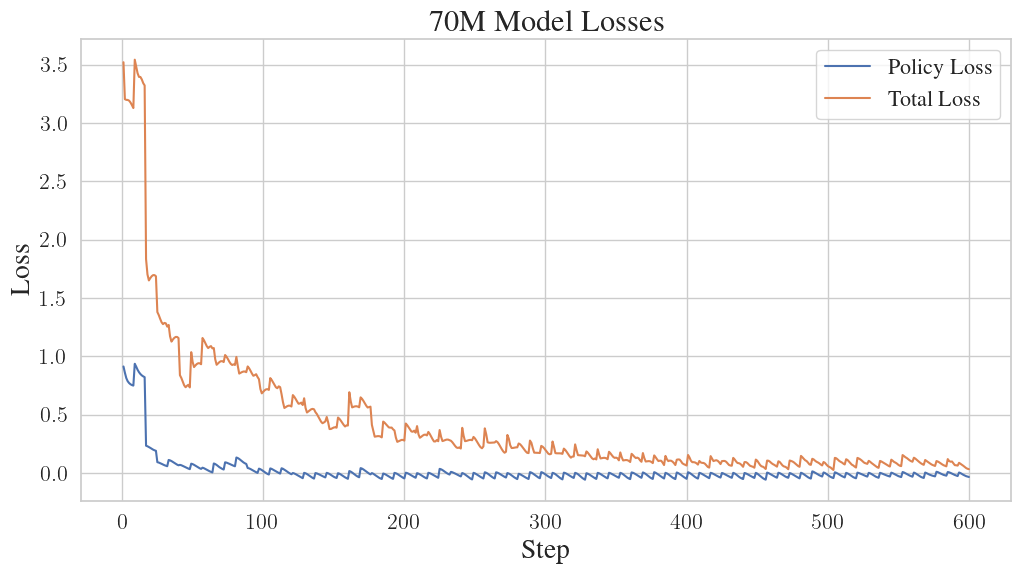

           Step  70m_losses_policy_loss  70m_losses_policy_loss__MIN  \
599  599.998999               -0.015664                    -0.015664   

     70m_losses_policy_loss__MAX  70m_losses_total_loss  \
599                    -0.015664               0.059762   

     70m_losses_total_loss__MIN  70m_losses_total_loss__MAX  
599                    0.059762                    0.059762  


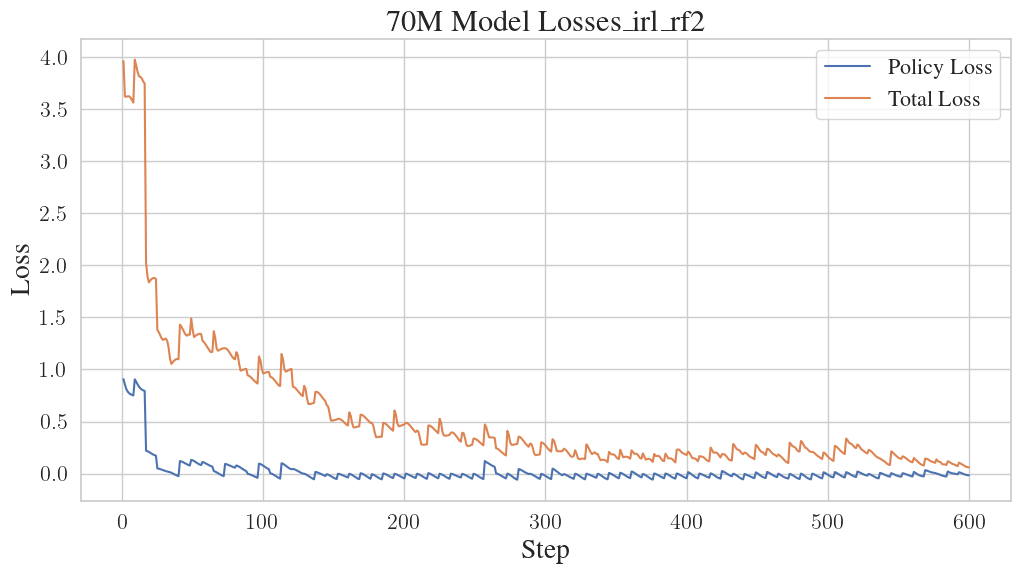

In [172]:
plot_run(model='70m', metric='losses', savefig=True, smoothing_alpha=0.999, comparison=False)
plot_run(model='70m', metric='losses_irl_RF2', savefig=False, smoothing_alpha=0.999, comparison=False) # irl

           Step  70m_returns_max  70m_returns_max__MIN  70m_returns_max__MAX  \
599  599.998999         2.464542              2.464542              2.464542   

     70m_returns_mean  70m_returns_mean__MIN  70m_returns_mean__MAX  \
599          0.260847               0.260847               0.260847   

     70m_returns_min  70m_returns_min__MIN  70m_returns_min__MAX  \
599        -1.744275             -1.744275             -1.744275   

     70m_returns_std  70m_returns_std__MIN  70m_returns_std__MAX  
599         0.662744              0.662744              0.662744  


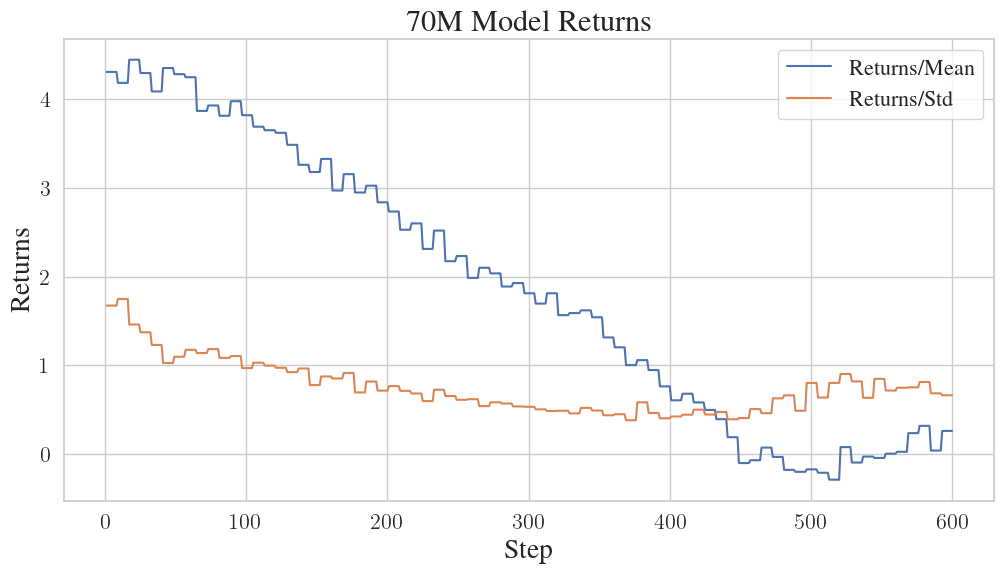

           Step  70m_returns_mean  70m_returns_mean__MIN  \
599  599.998999          0.247092               0.247092   

     70m_returns_mean__MAX  70m_returns_std  70m_returns_std__MIN  \
599               0.247092         0.903661              0.903661   

     70m_returns_std__MAX  
599              0.903661  


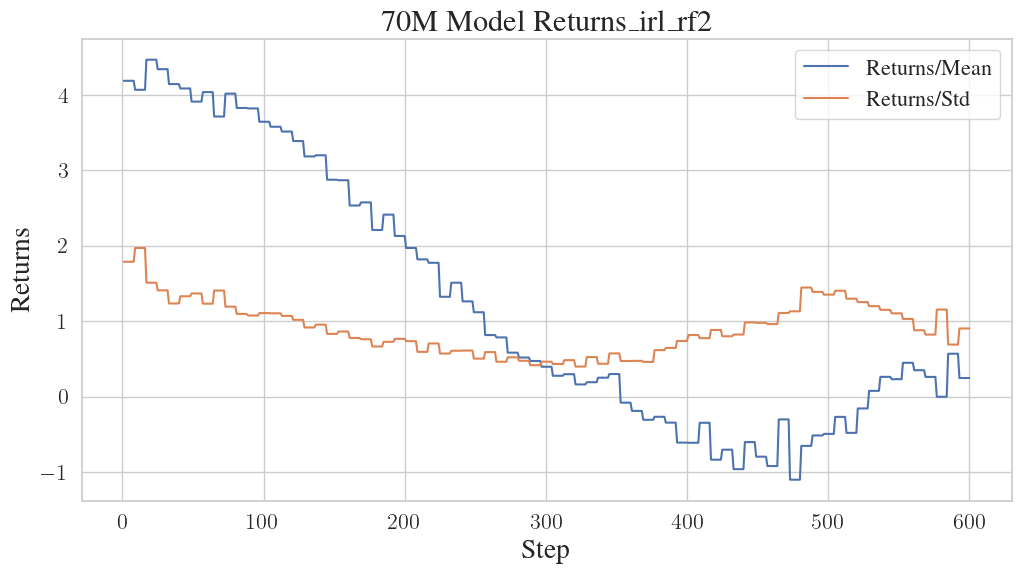

In [173]:
plot_run(model='70m', metric='returns', savefig=True, smoothing_alpha=0.999, comparison=False)
plot_run(model='70m', metric='returns_irl_RF2', savefig=False, smoothing_alpha=0.999, comparison=False) #irl

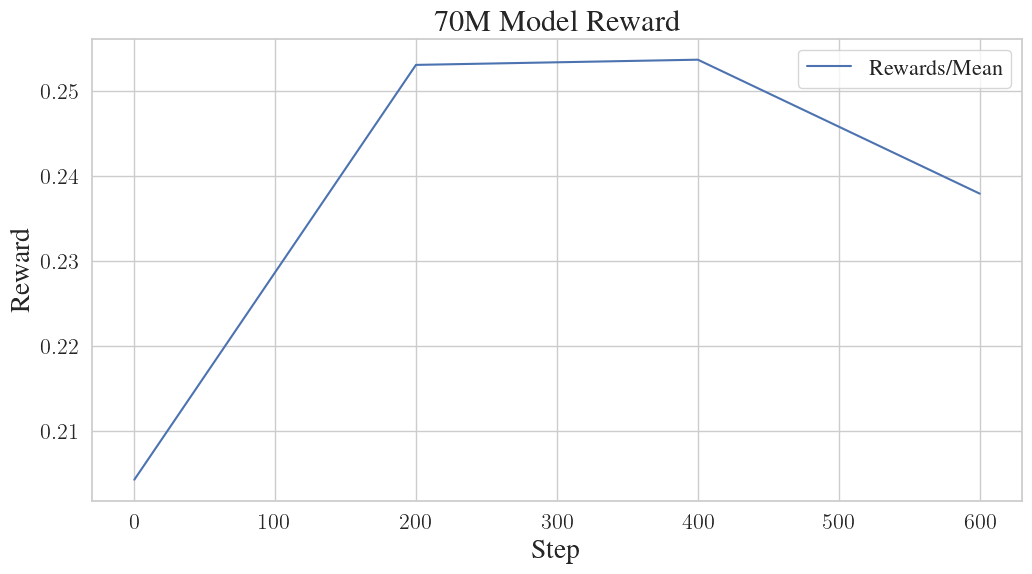

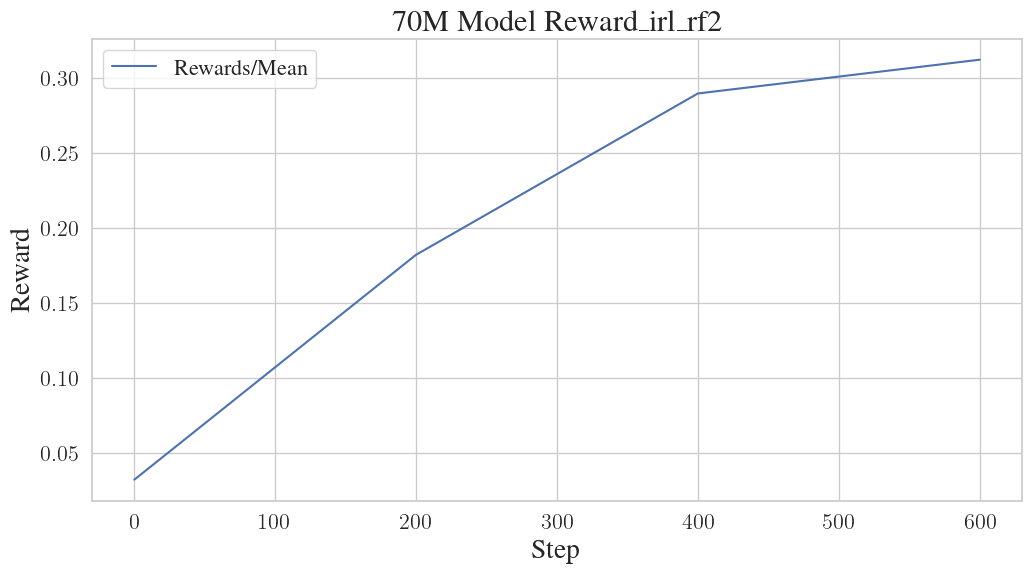

In [54]:
plot_run(model='70m', metric='reward', savefig=True, smoothing_alpha=0.999, comparison=False)
plot_run(model='70m', metric='reward_irl_RF2', savefig=False, smoothing_alpha=0.999, comparison=False) # irl

In [55]:
df_70m = pd.read_csv('../output/toxicity_results/rlhf_70m_toxicity_results.csv')
df_70m['ave_continuation_length'] = df_70m['Model Continuations'].apply(lambda x: np.mean([len(i) for i in literal_eval(x)]))
df_70m = df_70m[['Model', 'Toxicity Ratio', 'Mean Toxicity', 'ave_continuation_length']]
df_70m

,Model,Toxicity Ratio,Mean Toxicity,ave_continuation_length
0,pythia-70m,{'toxicity_ratio': 0.0625},0.084354,176.967500
1,eleuther-pythia70m-hh-sft,{'toxicity_ratio': 0.055865921787709494},0.057592,85.005587
2,roberta_tox_classifier_custom_jigsaw_70_lr_3e6_kl_0035_bs_16_steps_600_simple_new_reward,{'toxicity_ratio': 0.03580562659846547},0.055154,250.654731
3,irl_rm_10_epochs_lr_0.0001_repeated_58_ss_100_custom_jigsaw_70m_lr_3e6_kl_01_bs_16_steps_600_RF_2,{'toxicity_ratio': 0.026385224274406333},0.056418,78.124011
4,irl_rm_10_epochs_lr_0.0001_repeated_58_ss_100_custom_jigsaw_70m_lr_3e6_kl_0035_bs_16_steps_600_RF_2,{'toxicity_ratio': 0.0025},0.006643,111.627500


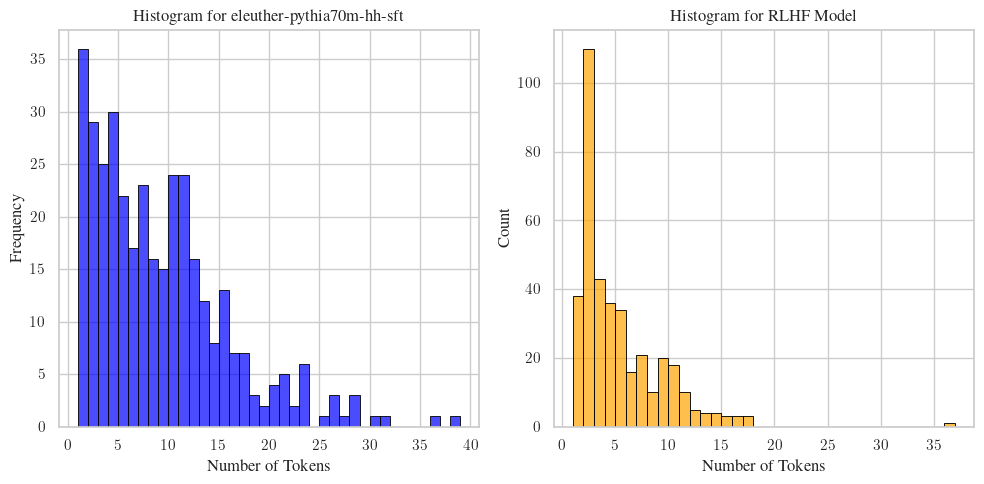

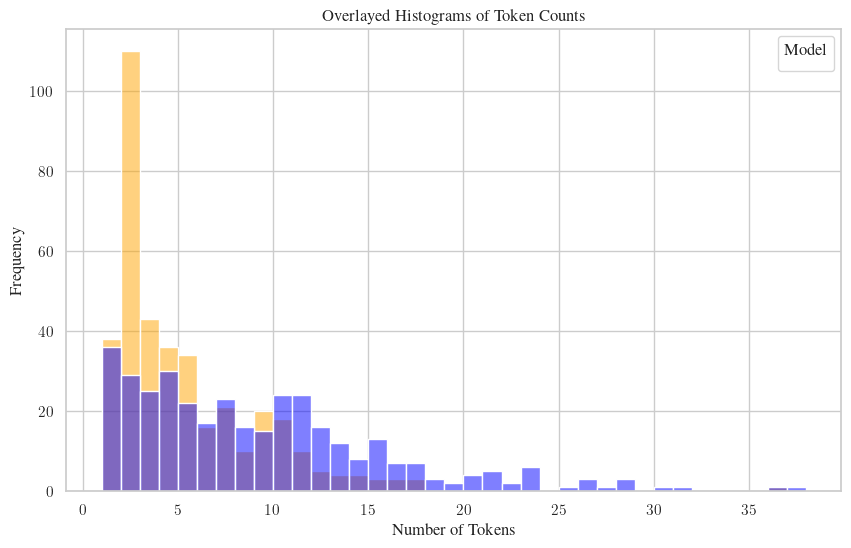

In [65]:
file = '../output/toxicity_results/rlhf_70m_toxicity_results.csv'
model_base = 'eleuther-pythia70m-hh-sft'
model_test = 'irl_rm_10_epochs_lr_0.0001_repeated_58_ss_100_custom_jigsaw_70m_lr_3e6_kl_01_bs_16_steps_600_RF_2'

results = create_token_count_results(file, model_base, model_test)
compare_histograms(results, unique=True)
compare_histograms_overlay(results, unique=True)

# 160m

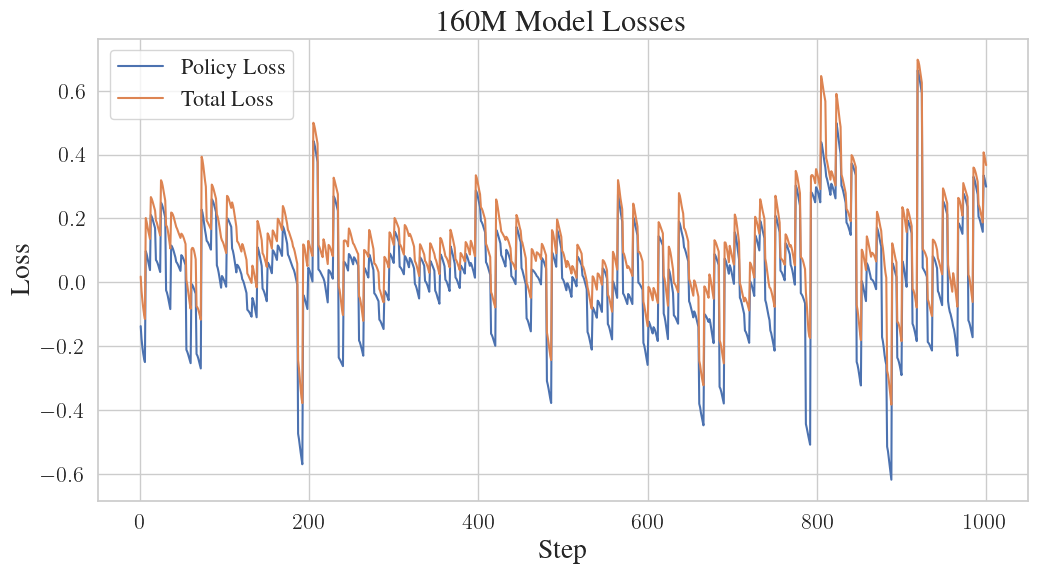

In [721]:
plot_run(model='160m', metric='losses', savefig=False, smoothing_alpha=0.999, comparison=False)

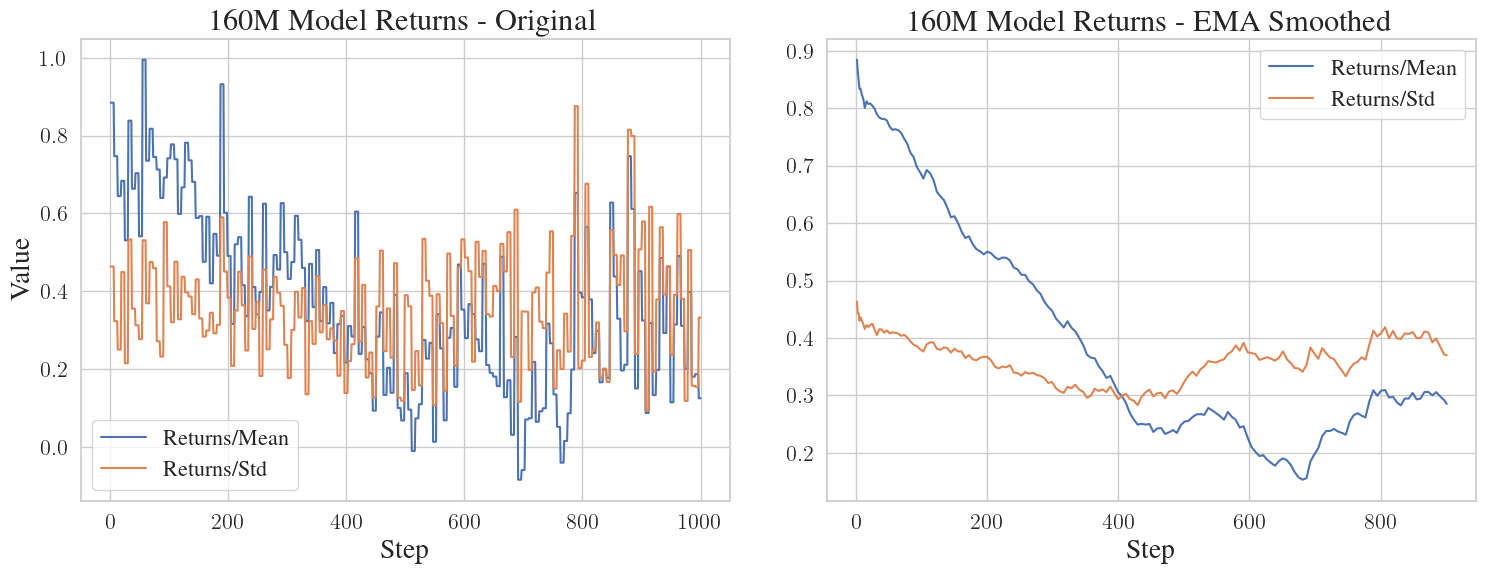

In [722]:
plot_run(model='160m', metric='returns', savefig=False, smoothing_alpha=0.01, comparison=True)

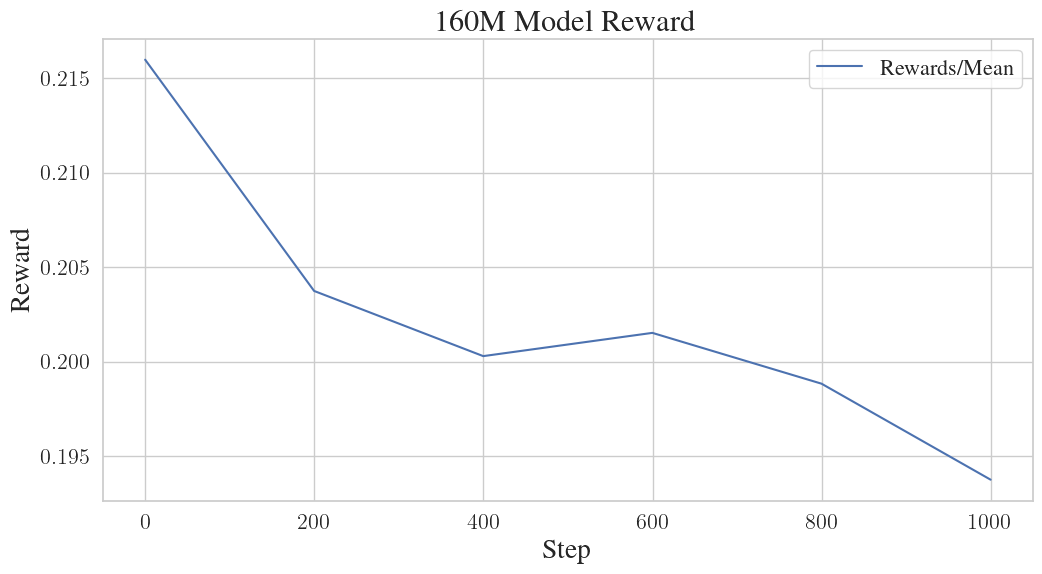

In [723]:
plot_run(model='160m', metric='reward', savefig=True, smoothing_alpha=0.999, comparison=False)

In [29]:
df_160m = pd.read_csv('../output/toxicity_results/rlhf_160m_toxicity_results.csv')
df_160m['ave_continuation_length'] = df_160m['Model Continuations'].apply(lambda x: np.mean([len(i) for i in literal_eval(x)]))
df_160m = df_160m[['Model', 'Toxicity Ratio', 'Mean Toxicity', 'ave_continuation_length']]
df_160m

,Model,Toxicity Ratio,Mean Toxicity,ave_continuation_length
0,pythia-160m,{'toxicity_ratio': 0.07},0.082415,180.995000
1,eleuther-pythia160m-hh-sft,{'toxicity_ratio': 0.05945945945945946},0.062037,105.456757
2,roberta_tox_classifier_custom_jigsaw_160_lr_1e6_kl_0035_steps_1000_epochs_1000_simple_new_reward,{'toxicity_ratio': 0.03910614525139665},0.041295,113.069832


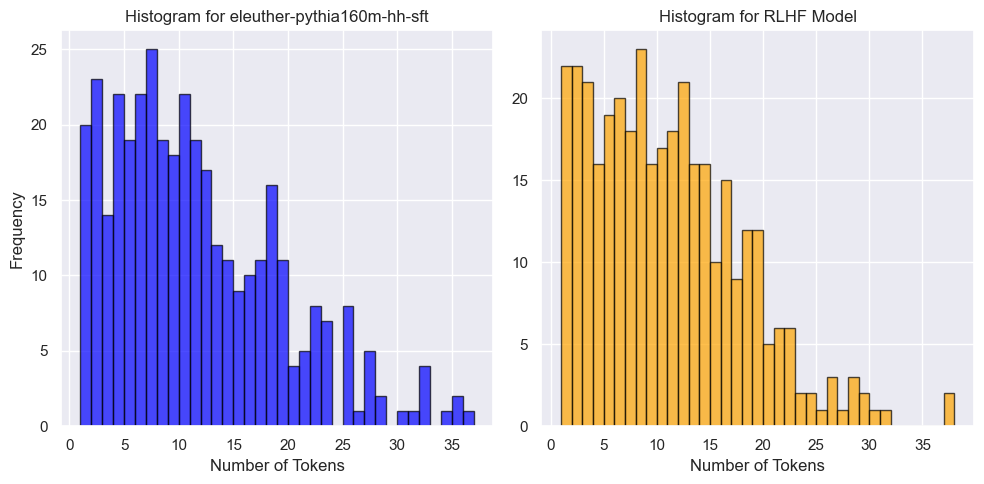

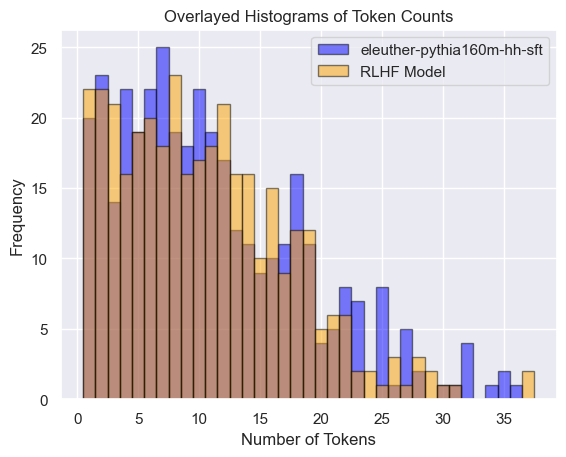

In [ ]:
file = '../output/toxicity_results/rlhf_160m_toxicity_results.csv'
model_base = 'eleuther-pythia160m-hh-sft'
model_test = 'roberta_tox_classifier_custom_jigsaw_160_lr_1e6_kl_0035_steps_1000_epochs_1000_simple_new_reward'

results = create_token_count_results(file, model_base, model_test)
compare_histograms(results, unique=True)
compare_histograms_overlay(results, unique=True)

# 410m

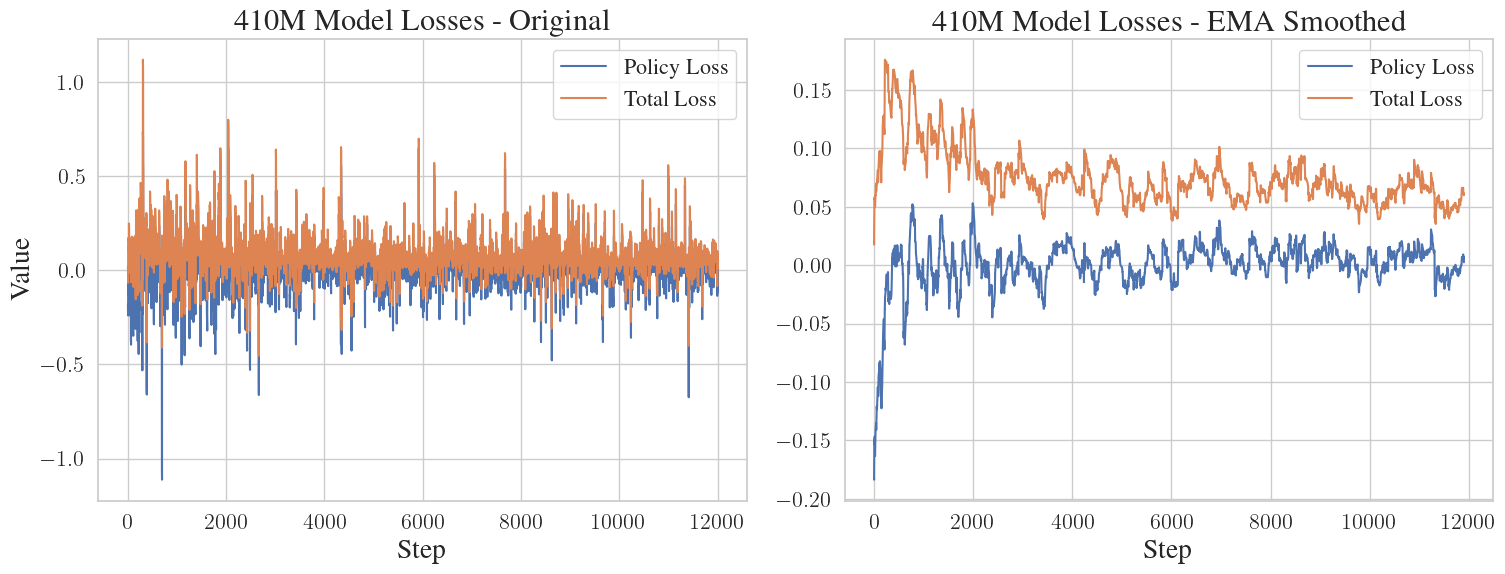

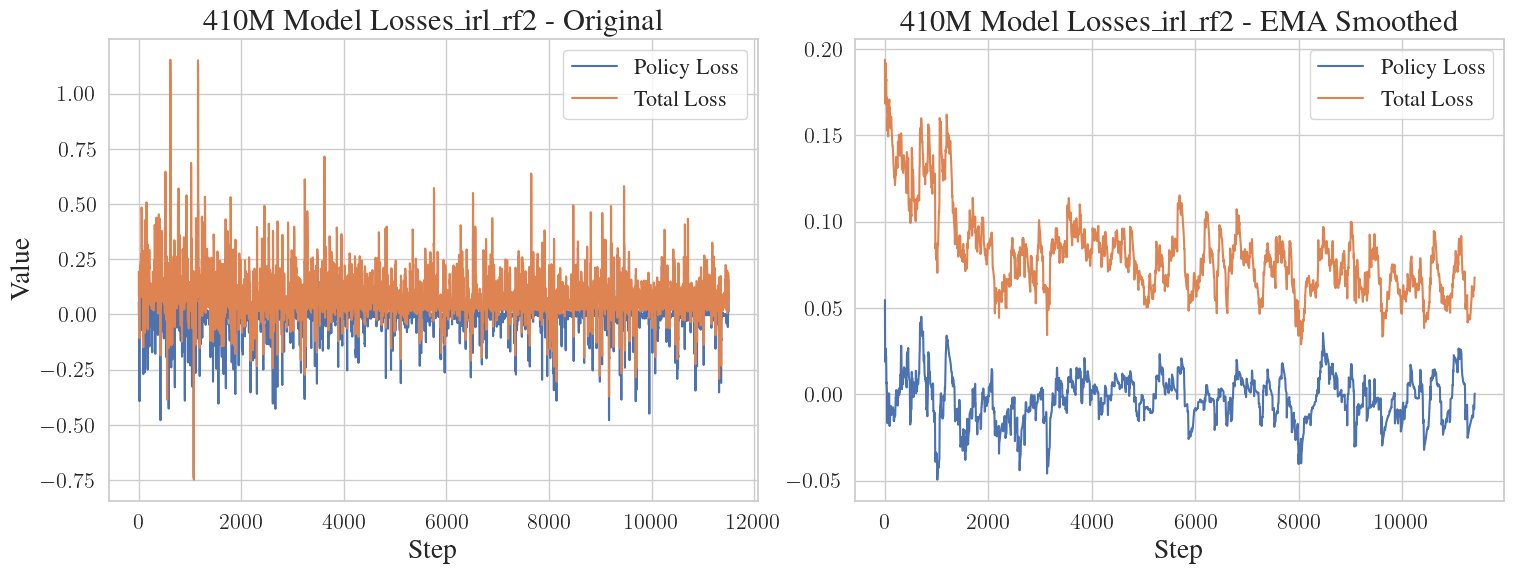

In [149]:
plot_run(model='410m_steps-12000', metric='losses', savefig=False, smoothing_alpha=0.01, comparison=True)
plot_run(model='410m_steps-12000', metric='losses_irl_RF2', savefig=False, smoothing_alpha=0.01, comparison=True) # irl

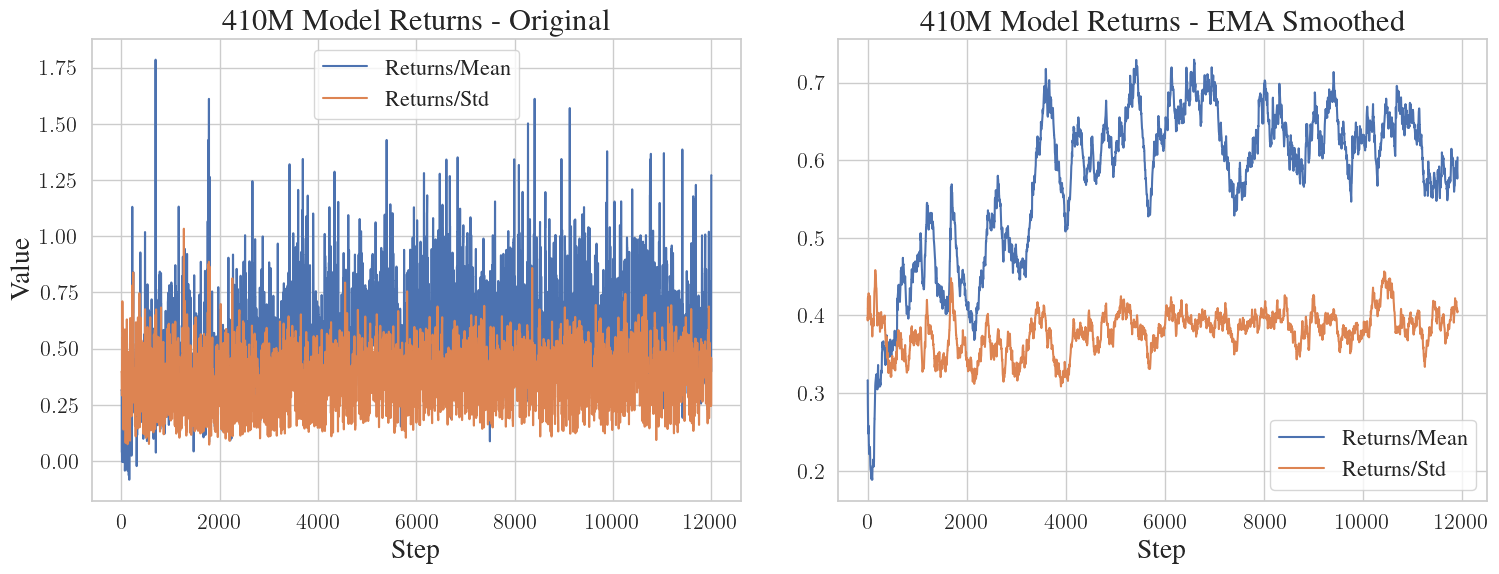

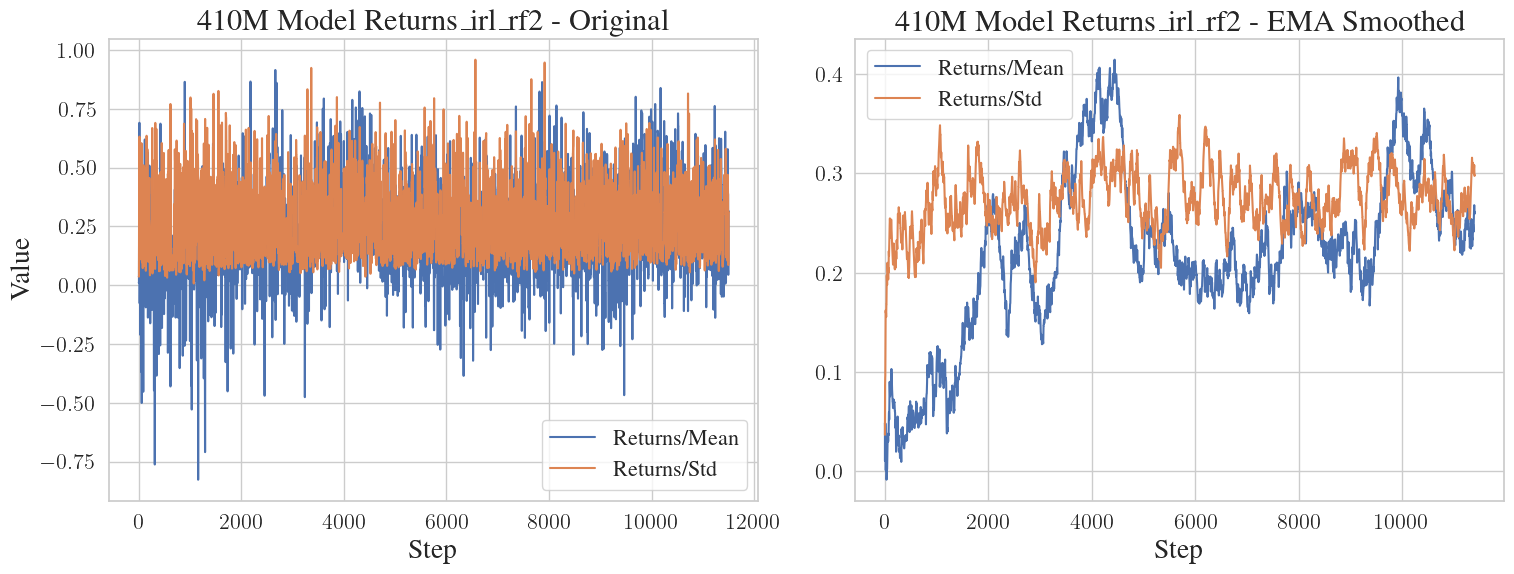

In [150]:
plot_run(model='410m_steps-12000', metric='returns', savefig=False, smoothing_alpha=0.01, comparison=True)
plot_run(model='410m_steps-12000', metric='returns_irl_RF2', savefig=False, smoothing_alpha=0.01, comparison=True) # irl

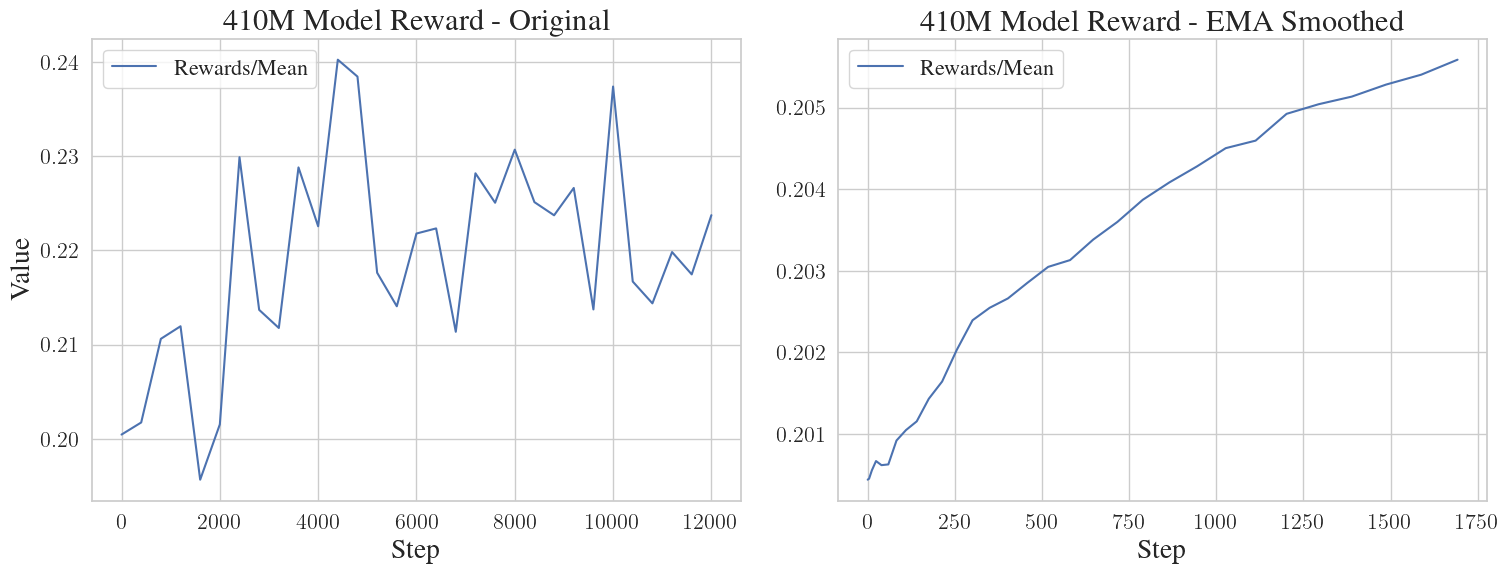

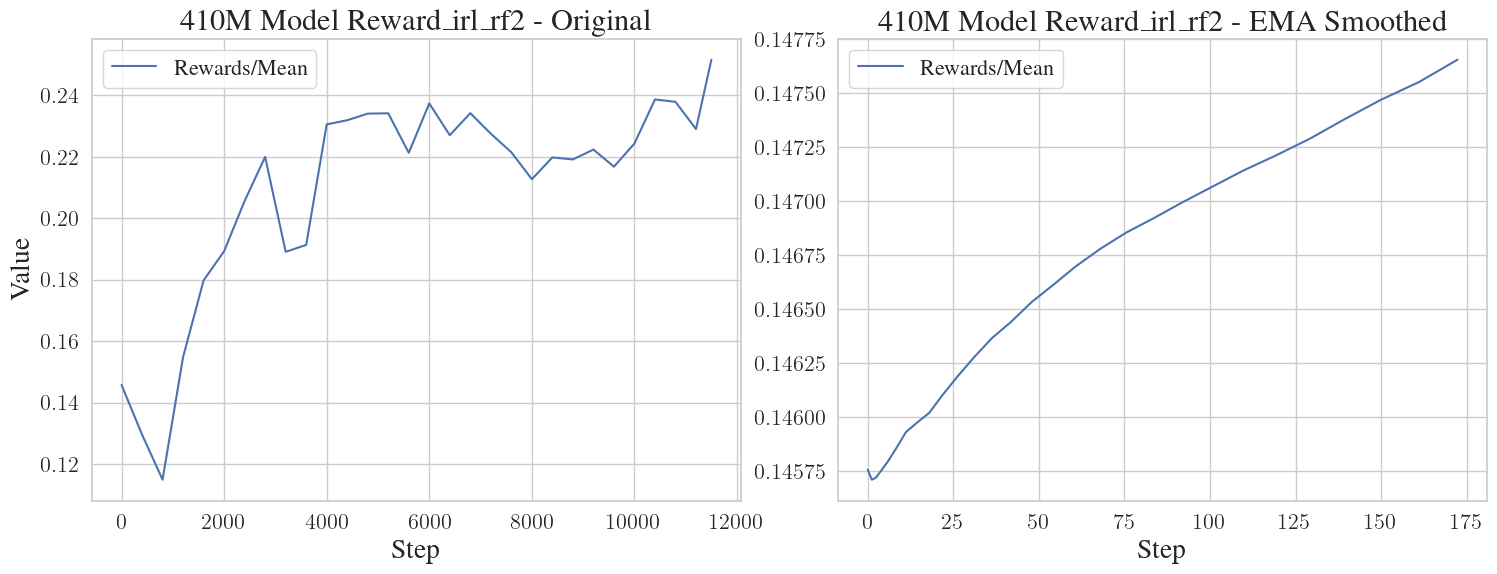

In [726]:
plot_run(model='410m_steps-12000', metric='reward', savefig=True, smoothing_alpha=0.01, comparison=True)
plot_run(model='410m_steps-12000', metric='reward_irl_RF2', savefig=False, smoothing_alpha=0.001, comparison=True) # irl

In [30]:
df_410m = pd.read_csv('../output/toxicity_results/rlhf_410m_toxicity_results.csv')
df_410m['ave_continuation_length'] = df_410m['Model Continuations'].apply(lambda x: np.mean([len(i) for i in literal_eval(x)]))
df_410m = df_410m[['Model', 'Toxicity Ratio', 'Mean Toxicity', 'ave_continuation_length']]
df_410m

,Model,Toxicity Ratio,Mean Toxicity,ave_continuation_length
0,pythia-410m,{'toxicity_ratio': 0.07268170426065163},0.088560,179.909774
1,eleuther-pythia410m-hh-sft,{'toxicity_ratio': 0.06770833333333333},0.076397,147.416667
2,roberta_tox_classifier_custom_jigsaw_410_lr_8e7_kl_01_steps_12000_simple_new_reward,{'toxicity_ratio': 0.0583756345177665},0.068165,167.845178
3,irl_rm_6_epochs_lr_1e-06_repeated_15_ss_200_custom_jigsaw_410m_lr_8e7_kl_01_bs_2_steps_11500_RF_2,{'toxicity_ratio': 0.0625},0.079089,186.670000


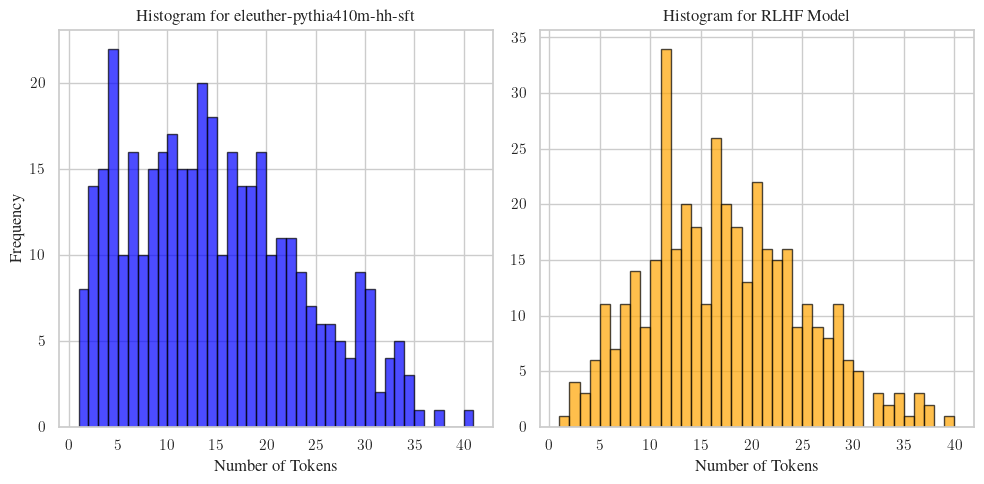

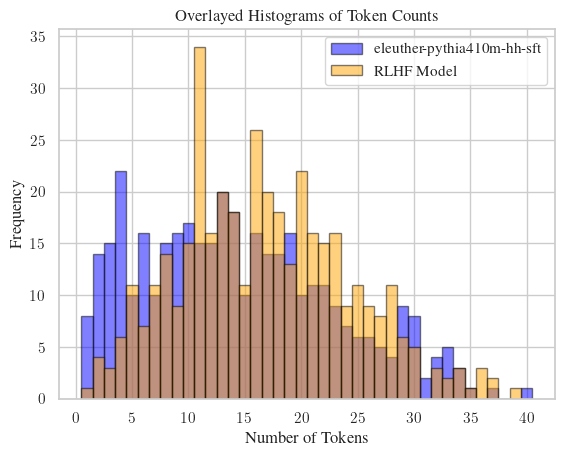

In [45]:
file = '../output/toxicity_results/rlhf_410m_toxicity_results.csv'
model_base = 'eleuther-pythia410m-hh-sft'
model_test = 'irl_rm_6_epochs_lr_1e-06_repeated_15_ss_200_custom_jigsaw_410m_lr_8e7_kl_01_bs_2_steps_11500_RF_2'

results = create_token_count_results(file, model_base, model_test)
compare_histograms(results, unique=True)
compare_histograms_overlay(results, unique=True)

# Toxicity Analysis

In [31]:
def get_toxicity_ratio(model, df):
    return ast.literal_eval(df[df['Model'] ==  model]['Toxicity Ratio'].iloc[0])['toxicity_ratio']

In [32]:
df_all = pd.concat([df_70m, df_160m, df_410m], axis=0)

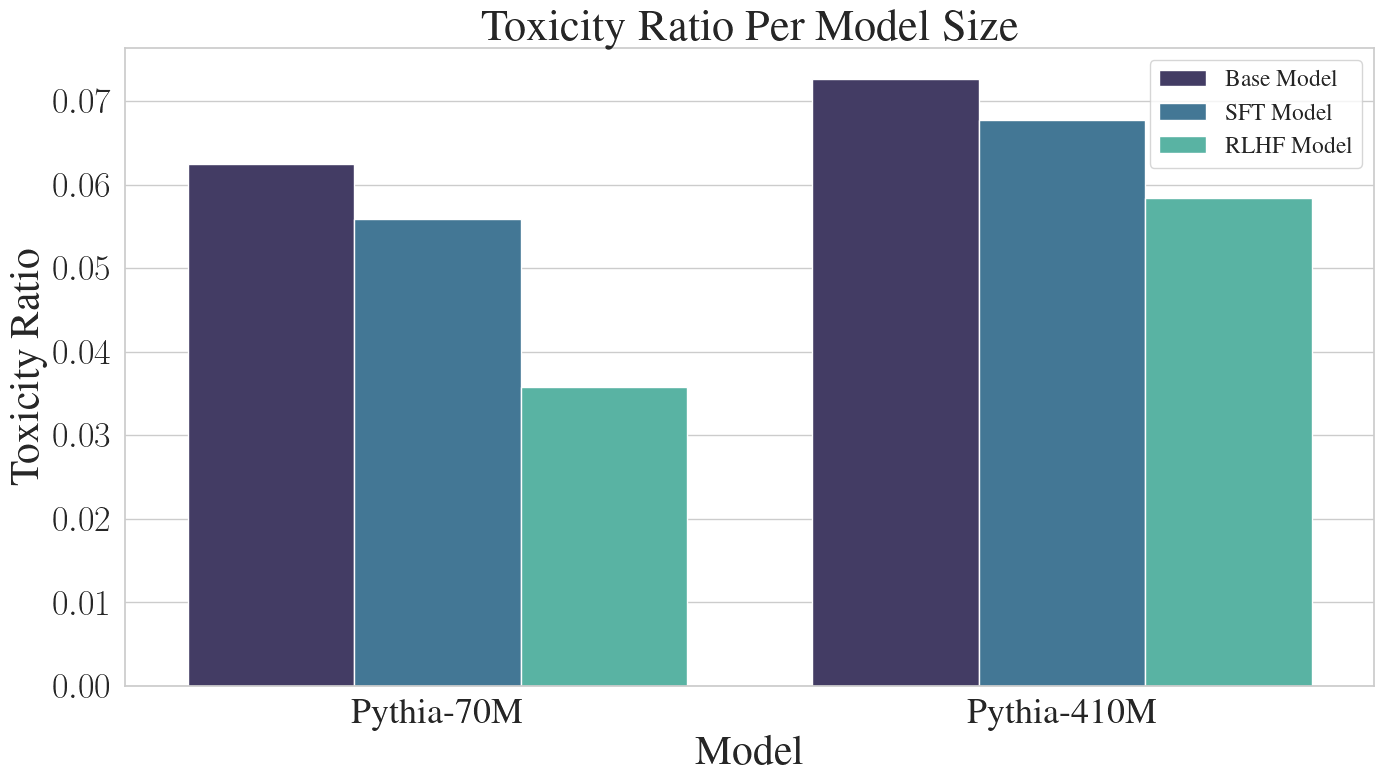

In [119]:
data = {
    'Category': ['Pythia-70M', 'Pythia-70M', 'Pythia-70M', 'Pythia-410M', 'Pythia-410M', 'Pythia-410M'],
    'Group': ['Base Model', 'SFT Model', 'RLHF Model', 'Base Model', 'SFT Model', 'RLHF Model'],
    'Value': [
        get_toxicity_ratio('pythia-70m', df_all), get_toxicity_ratio('eleuther-pythia70m-hh-sft', df_all), get_toxicity_ratio('roberta_tox_classifier_custom_jigsaw_70_lr_3e6_kl_0035_bs_16_steps_600_simple_new_reward', df_all), 
        get_toxicity_ratio('pythia-410m', df_all), get_toxicity_ratio('eleuther-pythia410m-hh-sft', df_all), get_toxicity_ratio('roberta_tox_classifier_custom_jigsaw_410_lr_8e7_kl_01_steps_12000_simple_new_reward', df_all),
]
}

toxicity_df = pd.DataFrame(data)

plt.figure(figsize=(14, 8))

sns.barplot(x='Category', y='Value', hue='Group', data=toxicity_df, palette='mako')

# Add labels and title
plt.title('Toxicity Ratio Per Model Size', size=32)
plt.xlabel('Model', size=30)
plt.ylabel('Toxicity Ratio', size=30)
plt.xticks(size=26)
plt.yticks(size=26)

plt.legend(fontsize=17)
plt.tight_layout()
plt.savefig('plots/rlhf/toxicity_ratio.png', dpi=600)

plt.show()

In [34]:
toxicity_df

,Category,Group,Value
0,70m,Base Model,0.062500
1,70m,SFT Model,0.055866
2,70m,RLHF Model,0.035806
3,160m,Base Model,0.070000
4,160m,SFT Model,0.059459
5,160m,RLHF Model,0.039106
6,410m,Base Model,0.072682
7,410m,SFT Model,0.067708
8,410m,RLHF Model,0.058376


In [734]:
def percentage_decrease(start, final):
    return ((start - final) / start) * 100

In [735]:
# 70m
base_sft_70m = percentage_decrease(get_toxicity_ratio('pythia-70m', df_all), get_toxicity_ratio('eleuther-pythia70m-hh-sft', df_all))
sft_rlhf_70m = percentage_decrease(get_toxicity_ratio('eleuther-pythia70m-hh-sft', df_all), get_toxicity_ratio('roberta_tox_classifier_custom_jigsaw_70_lr_3e6_kl_0035_bs_16_steps_600_simple_new_reward', df_all))

# 160m
base_sft_160m = percentage_decrease(get_toxicity_ratio('pythia-160m', df_all), get_toxicity_ratio('eleuther-pythia160m-hh-sft', df_all))
sft_rlhf_160m = percentage_decrease(get_toxicity_ratio('eleuther-pythia160m-hh-sft', df_all), get_toxicity_ratio('roberta_tox_classifier_custom_jigsaw_160_lr_1e6_kl_0035_steps_1000_epochs_1000_simple_new_reward', df_all))

# 410m
base_sft_410m = percentage_decrease(get_toxicity_ratio('pythia-410m', df_all), get_toxicity_ratio('eleuther-pythia410m-hh-sft', df_all))
sft_rlhf_410m = percentage_decrease(get_toxicity_ratio('eleuther-pythia410m-hh-sft', df_all), get_toxicity_ratio('roberta_tox_classifier_custom_jigsaw_410_lr_8e7_kl_01_steps_12000_simple_new_reward', df_all))

print('Percentage Decrease in Toxicity Ratio')
print('-------------------------------------')
print(f'70m Base to SFT: {base_sft_70m:.2f}%')
print(f'70m SFT to RLHF: {sft_rlhf_70m:.2f}%')
print('\n---------------------\n')
print(f'160m Base to SFT: {base_sft_160m:.2f}%')
print(f'160m SFT to RLHF: {sft_rlhf_160m:.2f}%')
print('---------------------\n')
print(f'410m Base to SFT: {base_sft_410m:.2f}%')
print(f'410m SFT to RLHF: {sft_rlhf_410m:.2f}%')

Percentage Decrease in Toxicity Ratio
-------------------------------------
70m Base to SFT: 10.61%
70m SFT to RLHF: 35.91%

---------------------

160m Base to SFT: 15.06%
160m SFT to RLHF: 34.23%
---------------------

410m Base to SFT: 6.84%
410m SFT to RLHF: 13.78%


In [736]:
percentage_decrease(0.0677, 0.0625)

7.68094534711964

# IRL

In [8]:
import numpy as np
from matplotlib.lines import Line2D
from scipy import stats
from scipy.spatial.distance import cosine
from sklearn.metrics import mean_squared_error

In [15]:
def calculate_corr(model, metrics, irl_file='irl', smoothing_alpha=None):
    results = []
    for metric in metrics:
        df_ori_rm = process_file(f'{model}_wandb_{metric}').ffill()
        df_irl_rm = process_file(f'{model}_wandb_{metric}_{irl_file}').ffill()

        # Optionally apply smoothing
        if smoothing_alpha is not None:
            df_ori_rm = df_ori_rm.ewm(alpha=smoothing_alpha, adjust=False).mean()
            df_irl_rm = df_irl_rm.ewm(alpha=smoothing_alpha, adjust=False).mean()

        rows = min(len(df_ori_rm), len(df_irl_rm))
        df_ori_rm = df_ori_rm[:rows]
        df_irl_rm = df_irl_rm[:rows]

        # print('lengths:', len(df_ori_rm), len(df_irl_rm))

        if metric == 'losses':
            ori_total_loss = df_ori_rm[f'{model}_losses_total_loss']
            irl_total_loss = df_irl_rm[f'{model}_losses_total_loss']
            ori_policy_loss = df_ori_rm[f'{model}_losses_policy_loss']
            irl_policy_loss = df_irl_rm[f'{model}_losses_policy_loss']
            results.append({
                'metric': metric,
                'comparison': 'total_loss',
                'pearscorr': np.corrcoef(ori_total_loss, irl_total_loss)[0,1],
                'kendalltau': stats.kendalltau(ori_total_loss, irl_total_loss)[0],
                'spearmancorr': stats.spearmanr(ori_total_loss, irl_total_loss)[0],
                'cosine': 1 - cosine(ori_total_loss, irl_total_loss), # cosine similarity
                'mse': mean_squared_error(ori_total_loss, irl_total_loss),
            })
            results.append({
                'metric': metric,
                'comparison': 'policy_loss',
                'pearscorr': np.corrcoef(ori_policy_loss, irl_policy_loss)[0,1],
                'kendalltau': stats.kendalltau(ori_policy_loss, irl_policy_loss)[0],
                'spearmancorr': stats.spearmanr(ori_policy_loss, irl_policy_loss)[0],
                'cosine': 1 - cosine(ori_policy_loss, irl_policy_loss),
                'mse': mean_squared_error(ori_policy_loss, irl_policy_loss),
            })
        elif metric == 'reward':
            ori_reward_mean = df_ori_rm[f'{model}_reward_mean']
            irl_reward_mean = df_irl_rm[f'{model}_reward_mean']
            results.append({
                'metric': metric,
                'comparison': 'reward_mean',
                'pearscorr': np.corrcoef(ori_reward_mean, irl_reward_mean)[0,1],
                'kendalltau': stats.kendalltau(ori_reward_mean, irl_reward_mean)[0],
                'spearmancorr': stats.spearmanr(ori_reward_mean, irl_reward_mean)[0],
                'cosine': 1 - cosine(ori_reward_mean, irl_reward_mean),
                'mse': mean_squared_error(ori_reward_mean, irl_reward_mean),
            })
        elif metric == 'returns':
            ori_returns_mean = df_ori_rm[f'{model}_returns_mean']
            irl_returns_mean = df_irl_rm[f'{model}_returns_mean']
            ori_returns_std = df_ori_rm[f'{model}_returns_std']
            irl_returns_std = df_irl_rm[f'{model}_returns_std']
            results.append({
                'metric': metric,
                'comparison': 'returns_mean',
                'pearscorr': np.corrcoef(ori_returns_mean, irl_returns_mean)[0,1],
                'kendalltau': stats.kendalltau(ori_returns_mean, irl_returns_mean)[0],
                'spearmancorr': stats.spearmanr(ori_returns_mean, irl_returns_mean)[0],
                'cosine': 1 - cosine(ori_returns_mean, irl_returns_mean),
                'mse': mean_squared_error(ori_returns_mean, irl_returns_mean),
            })
            results.append({
                'metric': metric,
                'comparison': 'returns_std',
                'pearscorr': np.corrcoef(ori_returns_std, irl_returns_std)[0,1],
                'kendalltau': stats.kendalltau(ori_returns_std, irl_returns_std)[0],
                'spearmancorr': stats.spearmanr(ori_returns_std, irl_returns_std)[0],
                'cosine': 1 - cosine(ori_returns_std, irl_returns_std),
                'mse': mean_squared_error(ori_returns_std, irl_returns_std),
            })
    
    # Convert list of dictionaries to a DataFrame
    df_results = pd.DataFrame(results)
    return df_results

In [234]:
def plot_rlhf_comparison(model, metrics, irl_file, savefig=False, smoothing_alpha=None):
    config = {
        'losses': {
            'value_vars': [f'{model}_losses_total_loss', f'{model}_losses_policy_loss'],
            'title': 'Total Loss and Policy Loss',
            'palette_colours': ['#ff7f0e', '#1f77b4', '#ffa447', '#4f91c5'],
            'labels': ['Original RLHF Total Loss', 'Original RLHF Policy Loss', 'IRL-RLHF Total Loss', 'IRL-RLHF Policy Loss']
        },
        'returns': {
            'value_vars': [f'{model}_returns_mean', f'{model}_returns_std'],
            'title': 'Returns/Mean and Returns/Std',
            'palette_colours': ['#1f77b4', '#ff7f0e', '#4f91c5', '#ffa447'],
            'labels': ['Original RLHF Returns/Mean', 'Original RLHF Returns/Std', 'IRL-RLHF Returns/Mean', 'IRL-RLHF Returns/Std']
        },
        'reward': {
            'value_vars': [f'{model}_reward_mean'],
            'title': 'Reward/Mean',
            'palette_colours': ['#1f77b4', '#4f91c5'],
            'labels': ['Original RLHF Reward/Mean', 'IRL-RLHF Reward/Mean']
        }
    }

    # Determine the number of columns for subplots
    num_metrics = len(metrics)

    # 1*3
    if num_metrics == 1:
        fig, axes = plt.subplots(1, num_metrics, figsize=(12, 6))
        axes = [axes]  # Ensure axes is always a list, even if it's a single plot
    else:
        fig, axes = plt.subplots(1, num_metrics, figsize=(24, 6))

    # # 3*1
    # if num_metrics == 1:
    #     fig, axes = plt.subplots(num_metrics, 1, figsize=(5, 6))
    #     axes = [axes]  # Ensure axes is always a list, even if it's a single plot
    # else:
    #     fig, axes = plt.subplots(num_metrics, 1, figsize=(10, 14))

    for i, metric in enumerate(metrics):
        # Load the two CSV files
        ori_df = process_file(f'{model}_wandb_{metric}')
        irl_df = process_file(f'{model}_wandb_{metric}_{irl_file}')

        # Apply smoothing if smoothing_alpha is provided
        if smoothing_alpha is not None:
            ori_df = ori_df.ewm(alpha=smoothing_alpha, adjust=False).mean()
            irl_df = irl_df.ewm(alpha=smoothing_alpha, adjust=False).mean()

            # normalize
            if metric == 'reward':
                for col in config[metric]['value_vars']:
                    ori_df[col] = (ori_df[col] - ori_df[col].min()) / (ori_df[col].max() - ori_df[col].min())
                irl_df[col] = (irl_df[col] - irl_df[col].min()) / (irl_df[col].max() - irl_df[col].min())

        # Add a column to each dataframe to identify the dataset
        ori_df['dataset'] = 'Original RLHF'
        irl_df['dataset'] = 'IRL RLHF'

        # Combine the data into one DataFrame
        df_combined = pd.concat([ori_df, irl_df], ignore_index=True)

        # Melt the DataFrame to make it long-form for seaborn
        df_melted = pd.melt(df_combined, id_vars=['Step', 'dataset'], 
                            value_vars=config[metric]['value_vars'], 
                            var_name='Type')

        # Create the line plot in the respective subplot
        sns.lineplot(
            data=df_melted, 
            x='Step', 
            y='value', 
            hue='Type', 
            style='dataset',
            palette=config[metric]['palette_colours'],  
            dashes=[(1, 0), (2, 2)],
            ax=axes[i],
            linewidth=3,
        )

        # Custom legend elements with shades
        legend_elements = []
        for j in range(len(config[metric]['value_vars']) * 2):
            if j < len(config[metric]['value_vars']):
                legend_elements.append(Line2D([0], [0], color=config[metric]['palette_colours'][j], lw=1, linestyle='-', label=config[metric]['labels'][j]))
            else:
                legend_elements.append(Line2D([0], [0], color=config[metric]['palette_colours'][j], lw=2, linestyle='--', label=config[metric]['labels'][j]))

        # Add the custom legend to the plot
        axes[i].legend(handles=legend_elements, title='', fontsize=17)

        # Set titles and labels for each subplot
        # axes[i].set_title(f"{config[metric]['title']}{' - EMA Smoothed' if smoothing_alpha is not None else ''}", size=24)
        axes[i].set_title(f"{config[metric]['title']}{'' if smoothing_alpha is not None else ''}", size=30)
        axes[i].set_xlabel('Steps', size=28)
        axes[i].set_ylabel('')
        axes[i].tick_params(axis='x', labelsize=22)
        axes[i].tick_params(axis='y', labelsize=22)
        if i == 0: 
            axes[i].set_ylabel('Value', size=28)

    # Adjust space between subplots
    plt.subplots_adjust(wspace=0.1)
    plt.tight_layout()

    if savefig:
        plt.savefig(f"plots/rlhf/{model}_RLHF_IRL_{''.join([x + '_' for x in metrics])}comparison.png", dpi=1200, transparent=True)
    plt.show()

## 70m

/var/folders/st/2r570j6x26l43xlczjpfdy7m0000gn/T/ipykernel_81038/1602250000.py:69: UserWarning: The palette list has more values (4) than needed (2), which may not be intended.
  sns.lineplot(
/var/folders/st/2r570j6x26l43xlczjpfdy7m0000gn/T/ipykernel_81038/1602250000.py:69: UserWarning: The palette list has more values (4) than needed (2), which may not be intended.
  sns.lineplot(
/var/folders/st/2r570j6x26l43xlczjpfdy7m0000gn/T/ipykernel_81038/1602250000.py:69: UserWarning: The palette list has more values (2) than needed (1), which may not be intended.
  sns.lineplot(


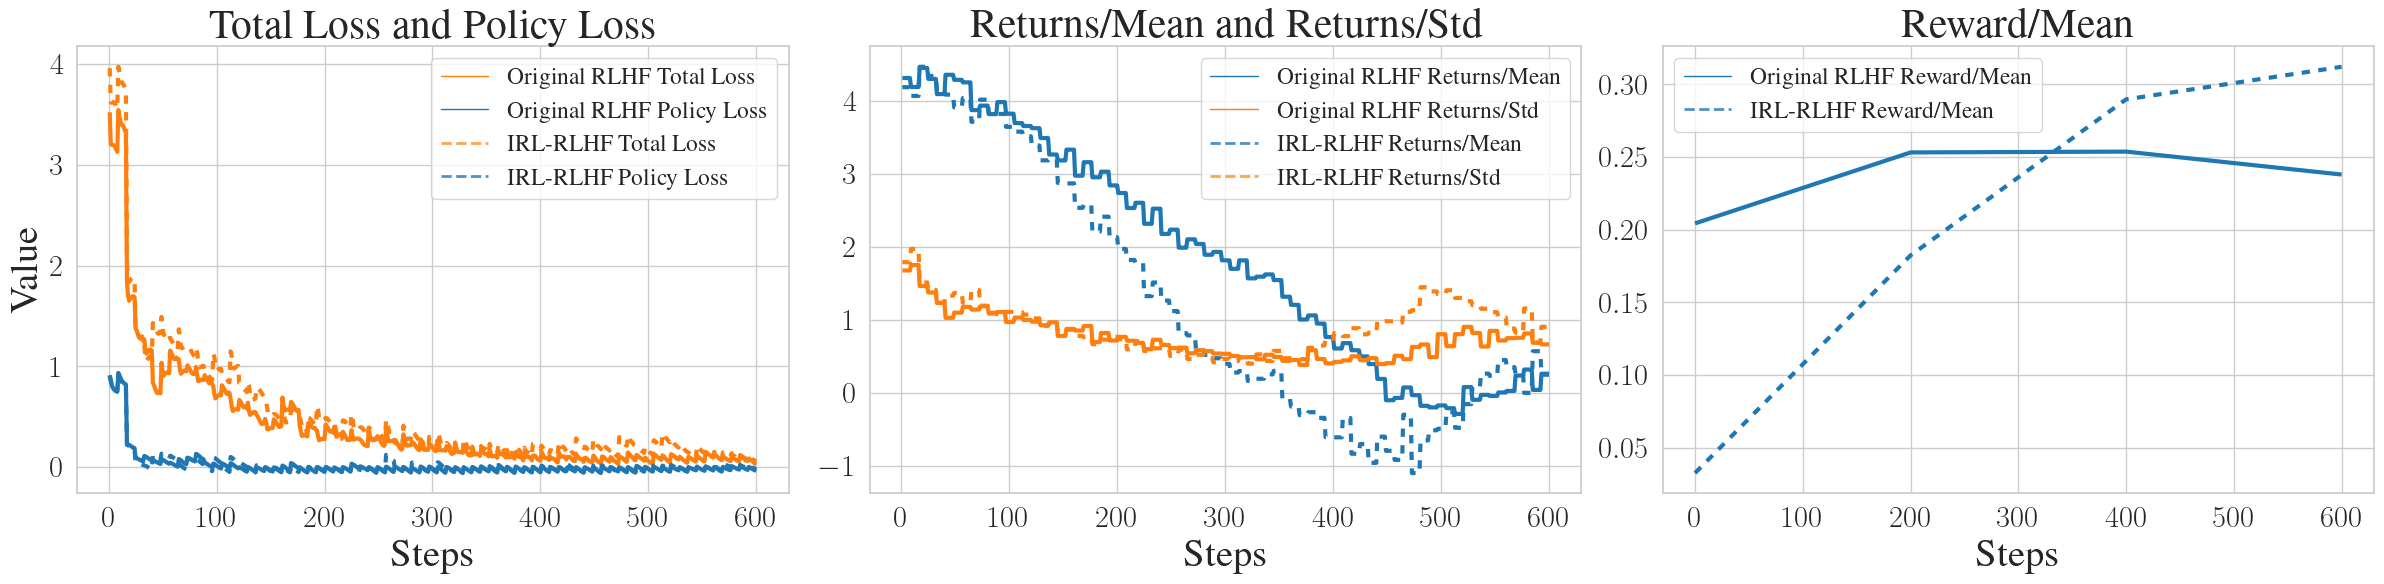

,metric,comparison,pearscorr,kendalltau,spearmancorr,cosine,mse
0,losses,total_loss,0.987373,0.756472,0.908627,0.990108,0.026898
1,losses,policy_loss,0.979391,0.622137,0.783553,0.979295,0.000834
2,returns,returns_mean,0.942976,0.794595,0.911124,0.937661,0.730706
3,returns,returns_std,0.723182,0.468108,0.618492,0.963636,0.084356
4,reward,reward_mean,0.765292,0.333333,0.400000,0.906826,0.010339


In [235]:
model = '70m'
metrics = ['losses', 'returns', 'reward']
irl_file = 'irl_RF2'
smoothing_alpha = None

plot_rlhf_comparison(model, metrics, irl_file, savefig=True, smoothing_alpha=smoothing_alpha)
calculate_corr(model, metrics, irl_file, smoothing_alpha=smoothing_alpha)

## 410m

/var/folders/st/2r570j6x26l43xlczjpfdy7m0000gn/T/ipykernel_81038/1602250000.py:69: UserWarning: The palette list has more values (4) than needed (2), which may not be intended.
  sns.lineplot(
/var/folders/st/2r570j6x26l43xlczjpfdy7m0000gn/T/ipykernel_81038/1602250000.py:69: UserWarning: The palette list has more values (4) than needed (2), which may not be intended.
  sns.lineplot(
/var/folders/st/2r570j6x26l43xlczjpfdy7m0000gn/T/ipykernel_81038/1602250000.py:69: UserWarning: The palette list has more values (2) than needed (1), which may not be intended.
  sns.lineplot(


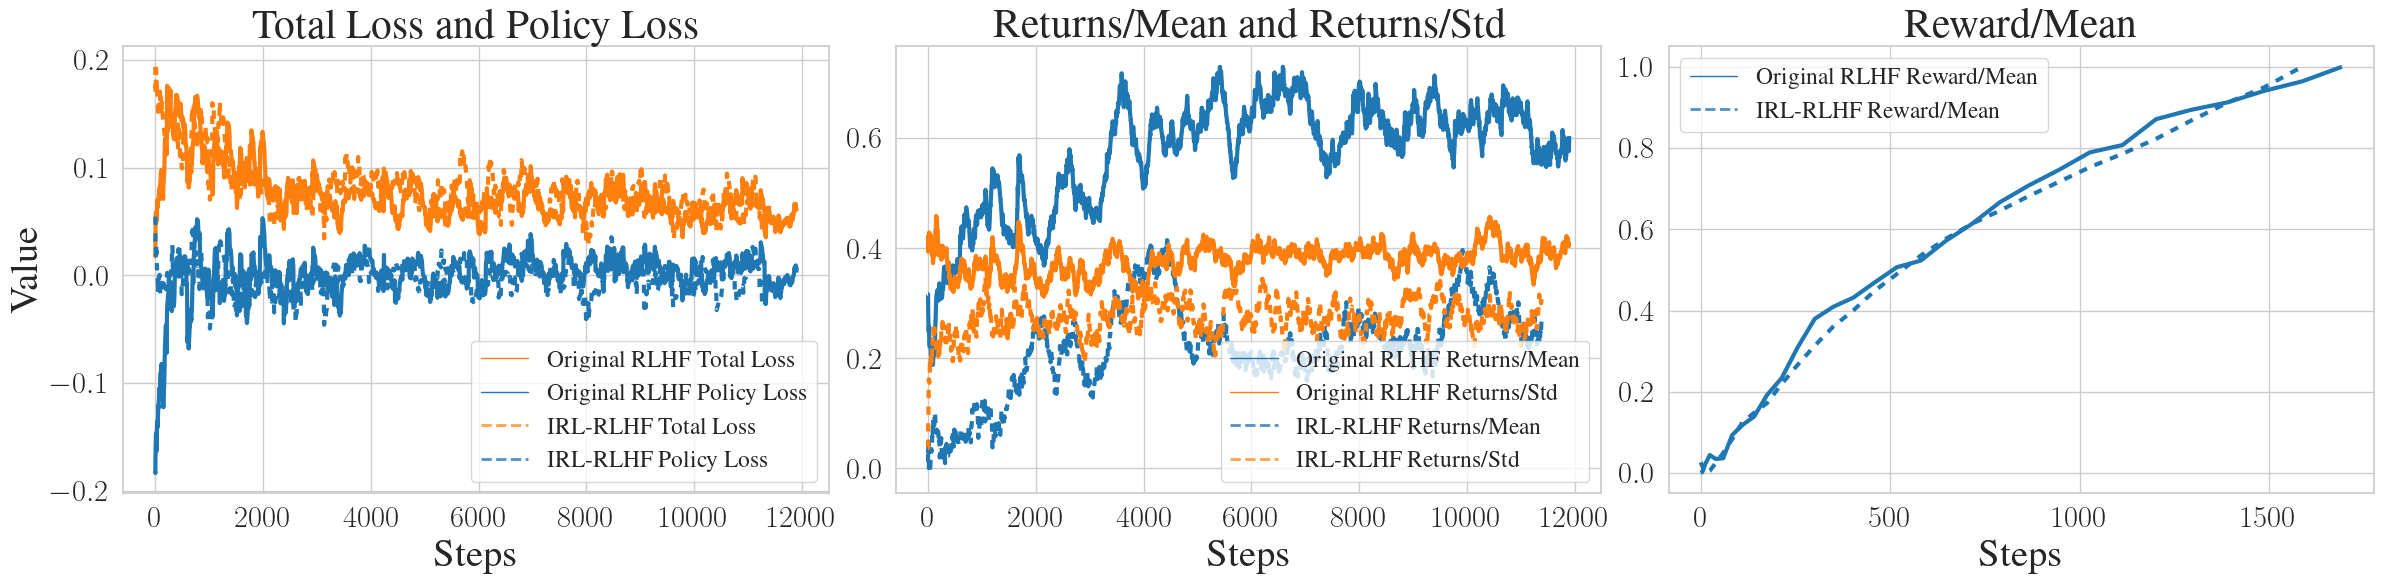

,metric,comparison,pearscorr,kendalltau,spearmancorr,cosine,mse
0,losses,total_loss,0.521354,0.301696,0.438185,0.954942,0.000650
1,losses,policy_loss,-0.042091,0.053999,0.079946,-0.044143,0.000906
2,returns,returns_mean,0.585397,0.276870,0.417003,0.956687,0.132170
3,returns,returns_std,-0.006636,0.009121,0.013392,0.989986,0.013637
4,reward,reward_mean,0.997345,0.963218,0.991546,0.999578,0.002496


In [237]:
model = '410m_steps-12000'
metrics = ['losses', 'returns', 'reward']
irl_file = 'irl_RF2'
smoothing_alpha = 0.01

plot_rlhf_comparison(model, metrics, irl_file, savefig=True, smoothing_alpha=smoothing_alpha)
calculate_corr(model, metrics, irl_file, smoothing_alpha=smoothing_alpha)

In [18]:
print("None:  ", calculate_corr(model, metrics, irl_file, smoothing_alpha=None)[['comparison', 'pearscorr']])
print("\n0.5:  ", calculate_corr(model, metrics, irl_file, smoothing_alpha=0.5)[['comparison', 'pearscorr']])
print("\n0.1:  ", calculate_corr(model, metrics, irl_file, smoothing_alpha=0.1)[['comparison', 'pearscorr']])
print("\n0.01:  ", calculate_corr(model, metrics, irl_file, smoothing_alpha=0.01)[['comparison', 'pearscorr']])
print("\n0.001:  ", calculate_corr(model, metrics, irl_file, smoothing_alpha=0.001)[['comparison', 'pearscorr']])
print("\n0.0001:  ", calculate_corr(model, metrics, irl_file, smoothing_alpha=0.0001)[['comparison', 'pearscorr']])

None:        comparison  pearscorr
0    total_loss   0.037368
1   policy_loss  -0.004688
2  returns_mean   0.097513
3   returns_std  -0.001277
4   reward_mean   0.545930

0.5:        comparison  pearscorr
0    total_loss   0.050352
1   policy_loss  -0.005400
2  returns_mean   0.124166
3   returns_std  -0.001682
4   reward_mean   0.809926

0.1:        comparison  pearscorr
0    total_loss   0.132966
1   policy_loss  -0.012355
2  returns_mean   0.290059
3   returns_std  -0.015630
4   reward_mean   0.987435

0.01:        comparison  pearscorr
0    total_loss   0.521354
1   policy_loss  -0.042091
2  returns_mean   0.585397
3   returns_std  -0.006636
4   reward_mean   0.997345

0.001:        comparison  pearscorr
0    total_loss   0.122757
1   policy_loss  -0.941052
2  returns_mean   0.884814
3   returns_std  -0.109118
4   reward_mean   0.997800

0.0001:        comparison  pearscorr
0    total_loss  -0.960093
1   policy_loss  -0.998851
2  returns_mean   0.990611
3   returns_std  -0.721205
4

In [35]:
df_all

,Model,Toxicity Ratio,Mean Toxicity,ave_continuation_length
0,pythia-70m,{'toxicity_ratio': 0.0625},0.084354,176.967500
1,eleuther-pythia70m-hh-sft,{'toxicity_ratio': 0.055865921787709494},0.057592,85.005587
2,roberta_tox_classifier_custom_jigsaw_70_lr_3e6_kl_0035_bs_16_steps_600_simple_new_reward,{'toxicity_ratio': 0.03580562659846547},0.055154,250.654731
3,irl_rm_10_epochs_lr_0.0001_repeated_58_ss_100_custom_jigsaw_70m_lr_3e6_kl_01_bs_16_steps_600_RF_2,{'toxicity_ratio': 0.026385224274406333},0.056418,78.124011
4,irl_rm_10_epochs_lr_0.0001_repeated_58_ss_100_custom_jigsaw_70m_lr_3e6_kl_0035_bs_16_steps_600_RF_2,{'toxicity_ratio': 0.0025},0.006643,111.627500
0,pythia-160m,{'toxicity_ratio': 0.07},0.082415,180.995000
1,eleuther-pythia160m-hh-sft,{'toxicity_ratio': 0.05945945945945946},0.062037,105.456757
2,roberta_tox_classifier_custom_jigsaw_160_lr_1e6_kl_0035_steps_1000_epochs_1000_simple_new_reward,{'toxicity_ratio': 0.03910614525139665},0.041295,113.069832
0,pythia-410m,{'toxicity_ratio': 0.07268170426065163},0.088560,179.909774
1,eleuther-pythia410m-hh-sft,{'toxicity_ratio': 0.06770833333333333},0.076397,147.416667


## Toxicity

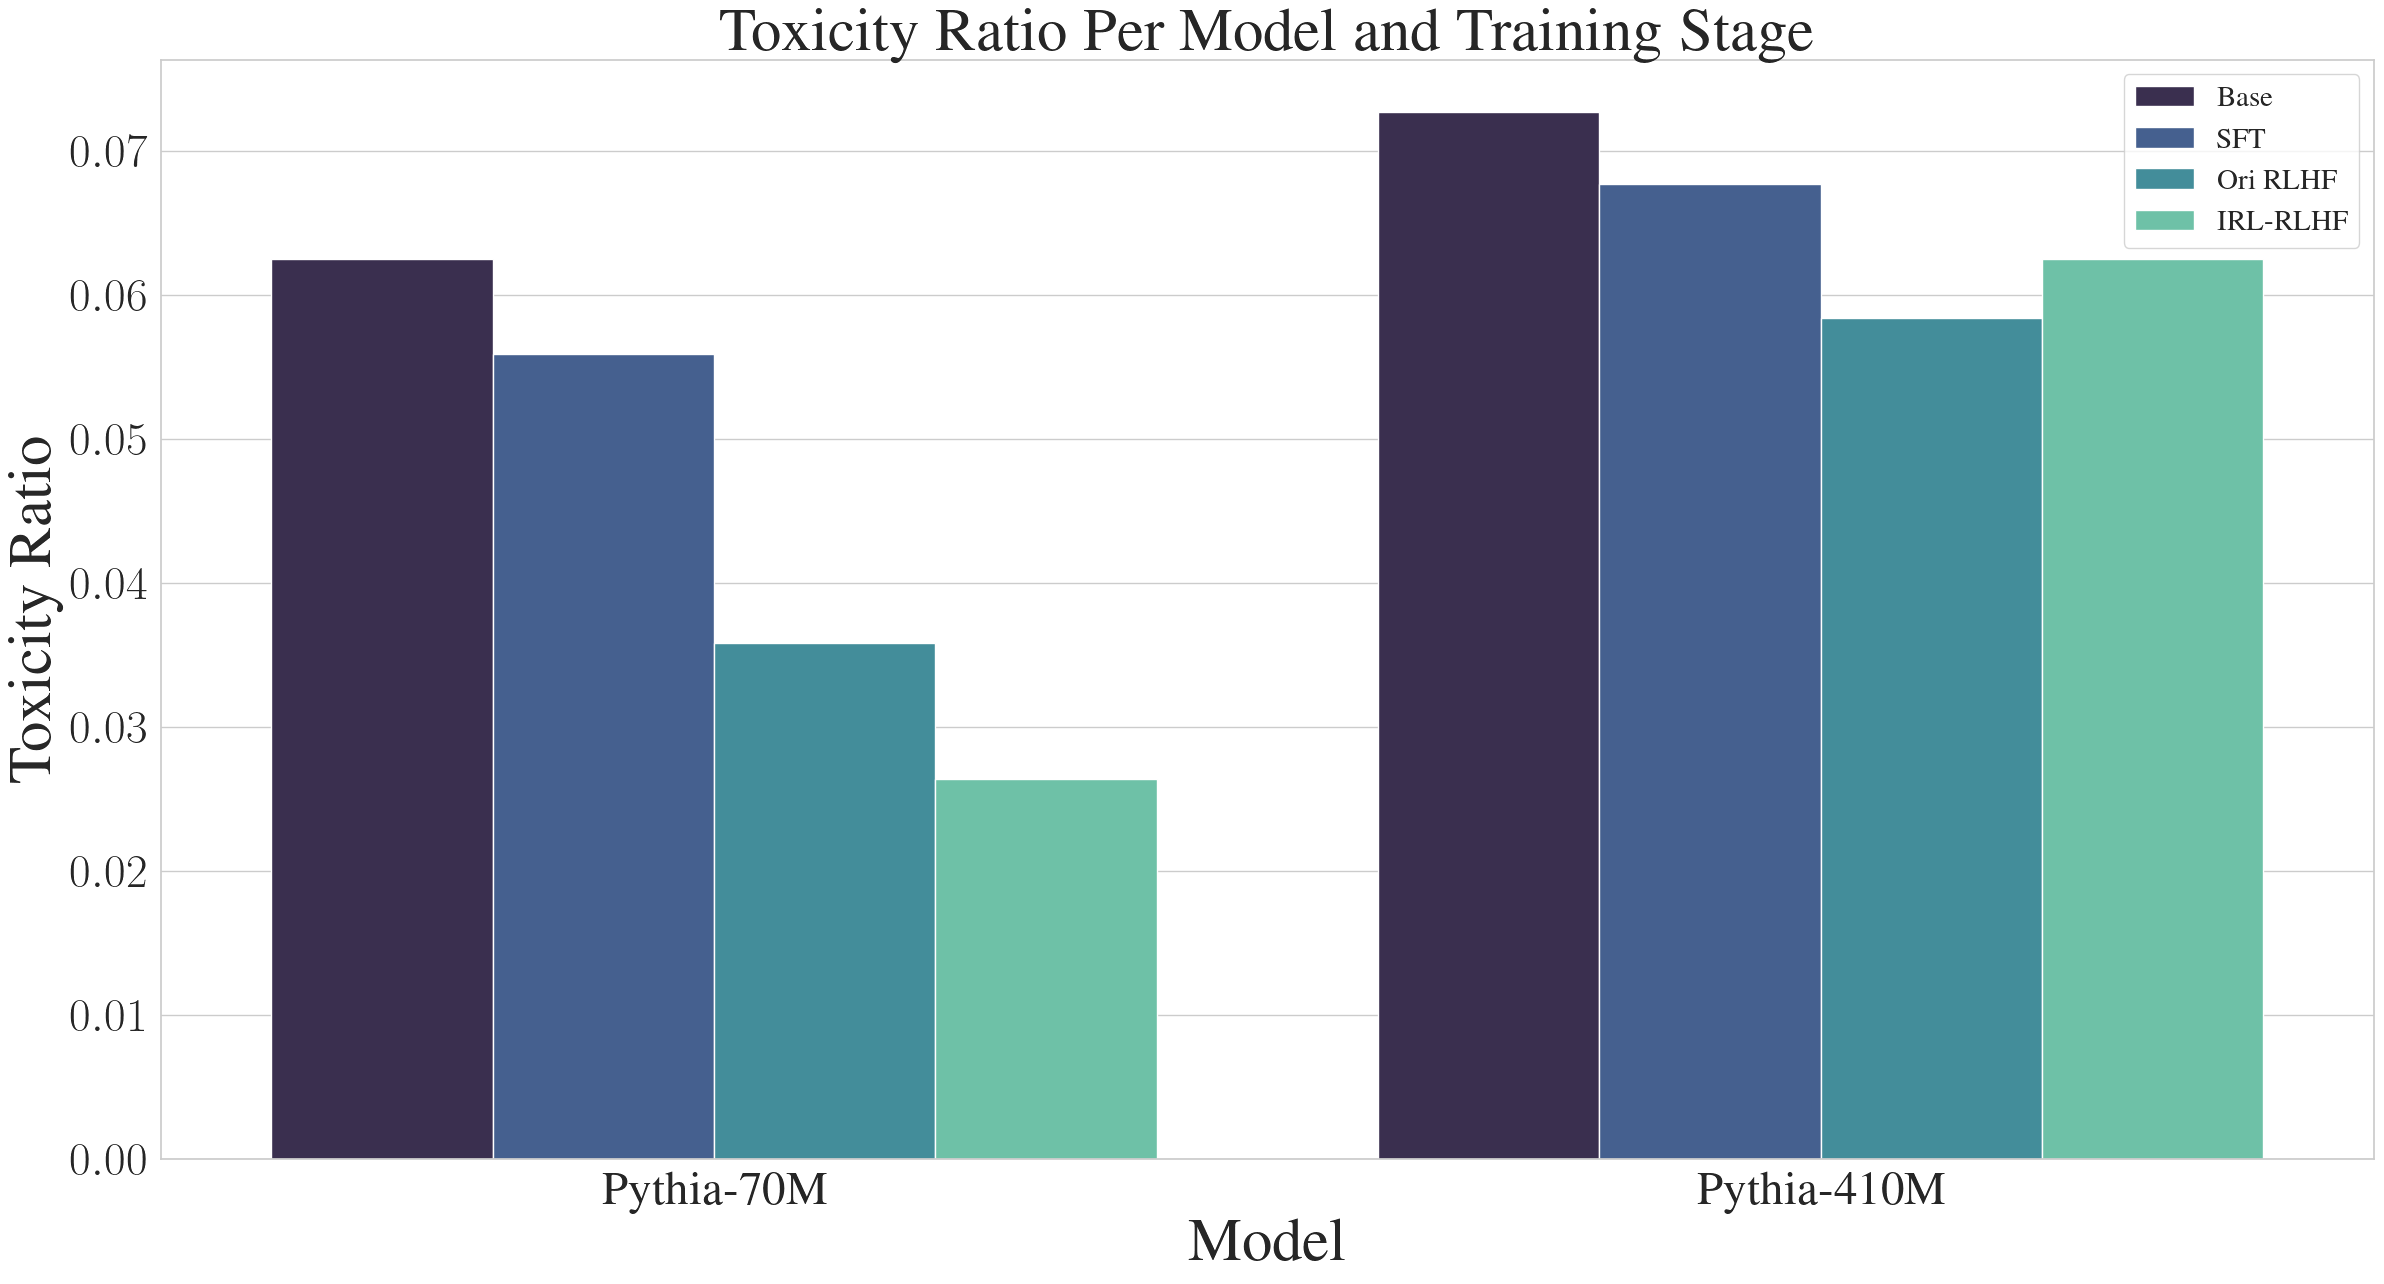

In [216]:
data = {
    'Category': ['Pythia-70M', 'Pythia-70M', 'Pythia-70M', 'Pythia-70M', 'Pythia-410M', 'Pythia-410M', 'Pythia-410M', 'Pythia-410M'],
    'Group': ['Base', 'SFT', 'Ori RLHF', 'IRL-RLHF', 'Base', 'SFT', 'Ori RLHF', 'IRL-RLHF'],
    'Value': [
        get_toxicity_ratio('pythia-70m', df_all), get_toxicity_ratio('eleuther-pythia70m-hh-sft', df_all), get_toxicity_ratio('roberta_tox_classifier_custom_jigsaw_70_lr_3e6_kl_0035_bs_16_steps_600_simple_new_reward', df_all), get_toxicity_ratio('irl_rm_10_epochs_lr_0.0001_repeated_58_ss_100_custom_jigsaw_70m_lr_3e6_kl_01_bs_16_steps_600_RF_2', df_all), 
        get_toxicity_ratio('pythia-410m', df_all), get_toxicity_ratio('eleuther-pythia410m-hh-sft', df_all), get_toxicity_ratio('roberta_tox_classifier_custom_jigsaw_410_lr_8e7_kl_01_steps_12000_simple_new_reward', df_all), get_toxicity_ratio('irl_rm_6_epochs_lr_1e-06_repeated_15_ss_200_custom_jigsaw_410m_lr_8e7_kl_01_bs_2_steps_11500_RF_2', df_all)
]
}

toxicity_df = pd.DataFrame(data)

plt.figure(figsize=(24, 13))

sns.barplot(x='Category', y='Value', hue='Group', data=toxicity_df, palette='mako')

# Add labels and title
plt.title('Toxicity Ratio Per Model and Training Stage', size=44)
plt.xlabel('Model', size=44)
plt.ylabel('Toxicity Ratio', size=44)
plt.xticks(size=34)
plt.yticks(size=34)

plt.legend(fontsize=21)
plt.tight_layout()
plt.savefig('plots/rlhf/toxicity_ratio_70m_410m.png', dpi=1200, transparent=True)

plt.show()